## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [44]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px 

In [45]:
# Random state seed
rseed = 42

## Load and explore data

In [46]:
# Import the dataset
countries_df = pd.read_csv("Country-data.csv")
print("Data: ")
print(countries_df.head())



Data: 
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [47]:
# Check the shape
print(countries_df.shape)

(167, 10)


In [48]:
# Check datatypes & counts
print("Data types for each features: ")
print(countries_df.info())

Data types for each features: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [50]:
# Identify any missing data
print("Missing values: ")
print(countries_df.isnull().sum())

Missing values: 
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [51]:
# Drop any non-numeric features (columns)
df = countries_df.drop(columns=['country'])
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [52]:
# Create a correlation map of features to explore relationships between features
corr = df.corr()
corr

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


<Axes: >

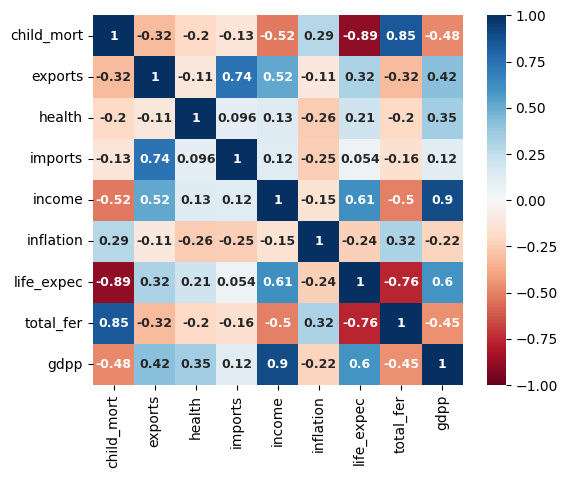

In [53]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True,
            annot_kws={'fontsize':9, 'fontweight': 'bold'})



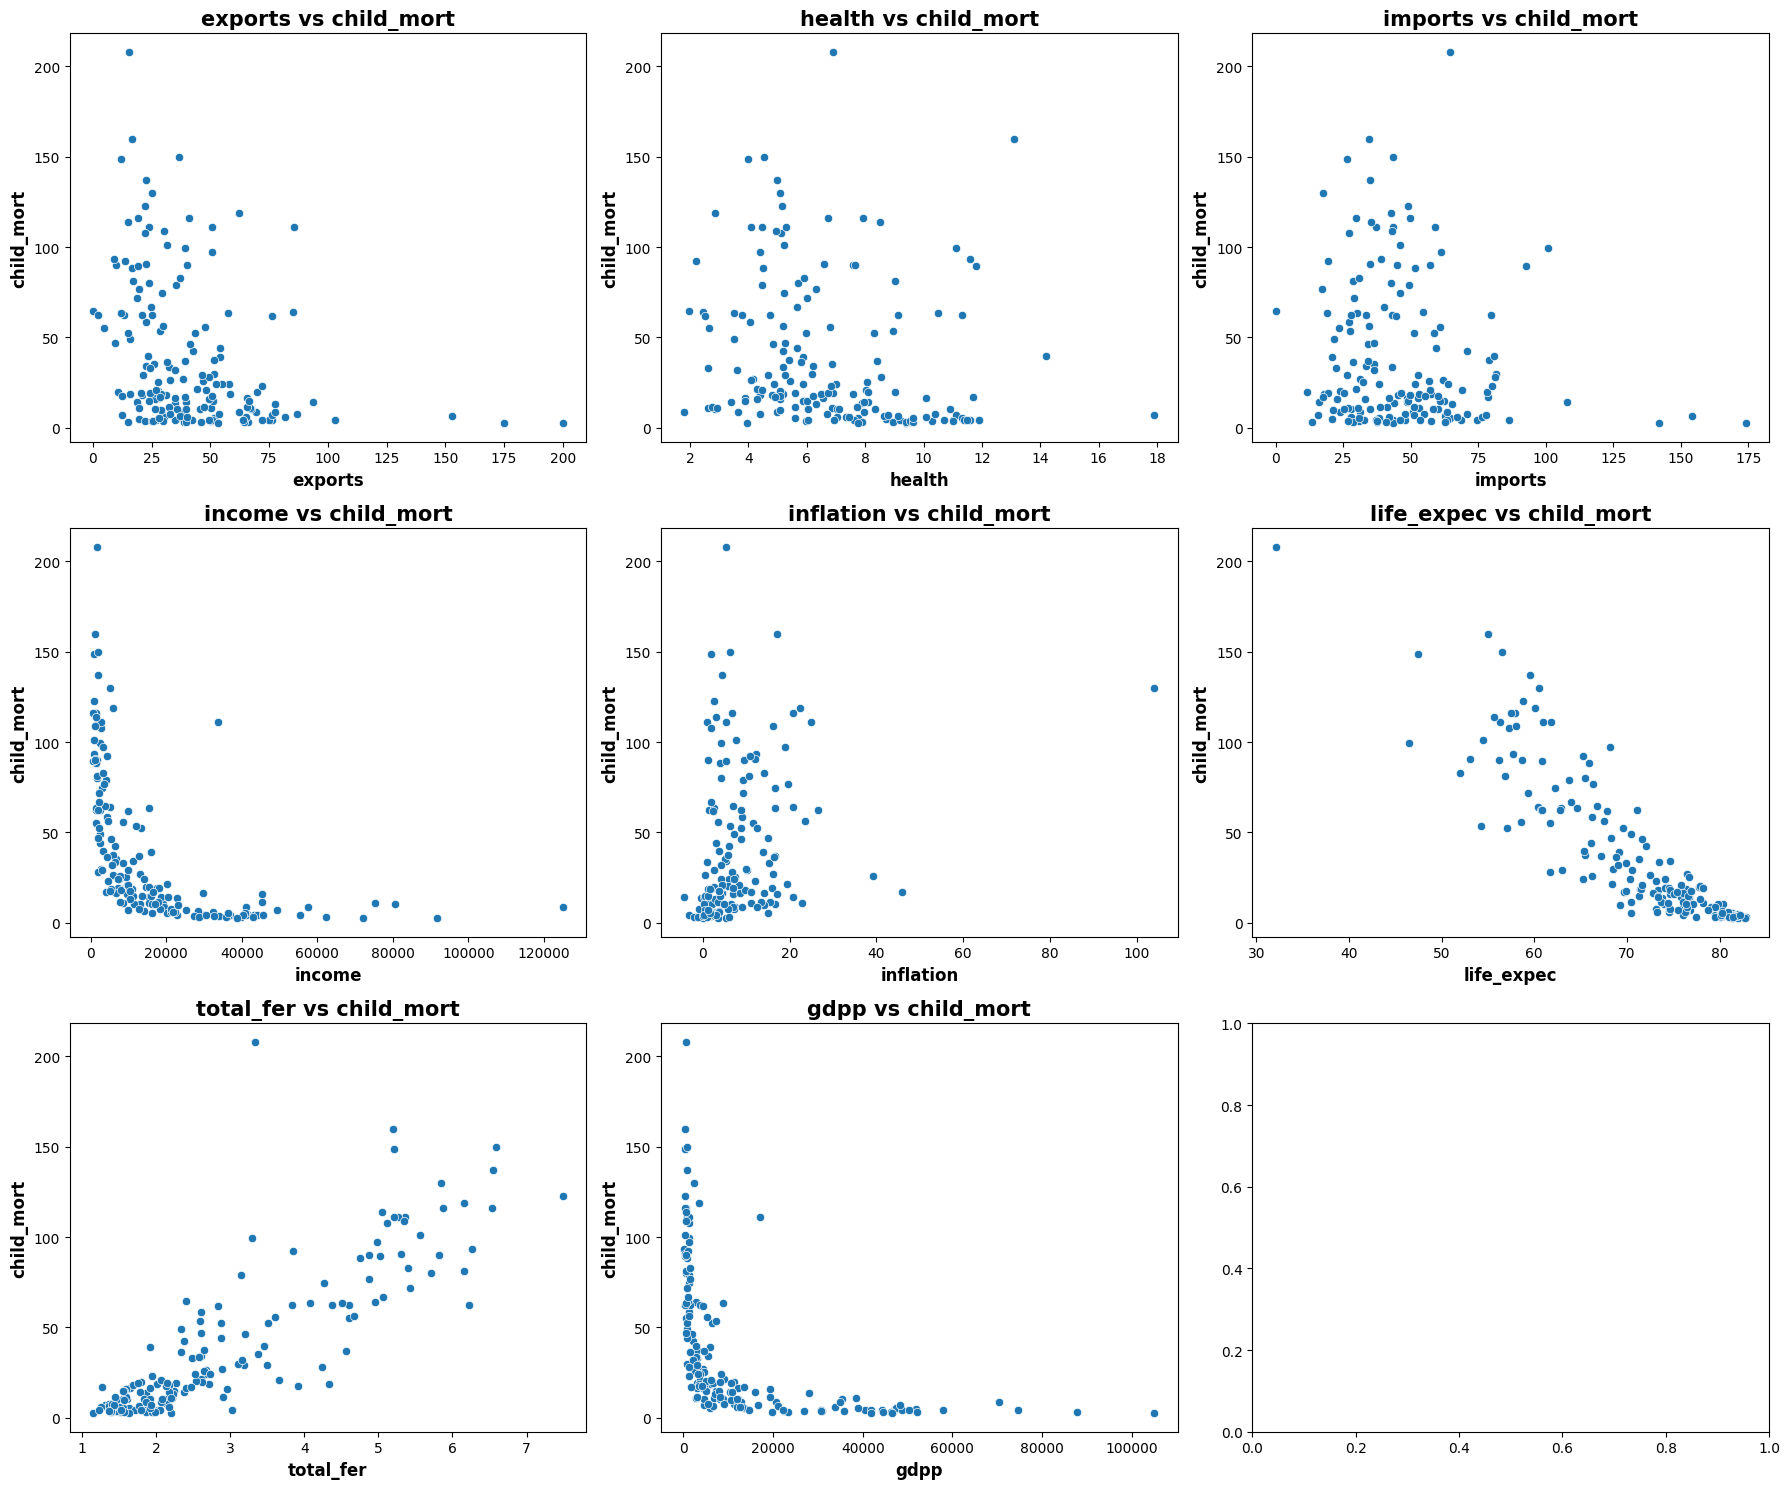

In [54]:
# Explore the continuous independent features against child_mort using scatter plots.
features_1 = df.columns[1:9]
child_mort = df.columns[0]

fig, axes = plt.subplots(3,3, figsize=(18,15))
axes = axes.flatten()

for i, feature in enumerate(features_1):
    sns.scatterplot(x=df[feature], y=df[child_mort], ax=axes[i])
    axes[i].set_title(f"{feature} vs {child_mort}", fontsize=15, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12, fontweight='bold')
    axes[i].set_ylabel(child_mort, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


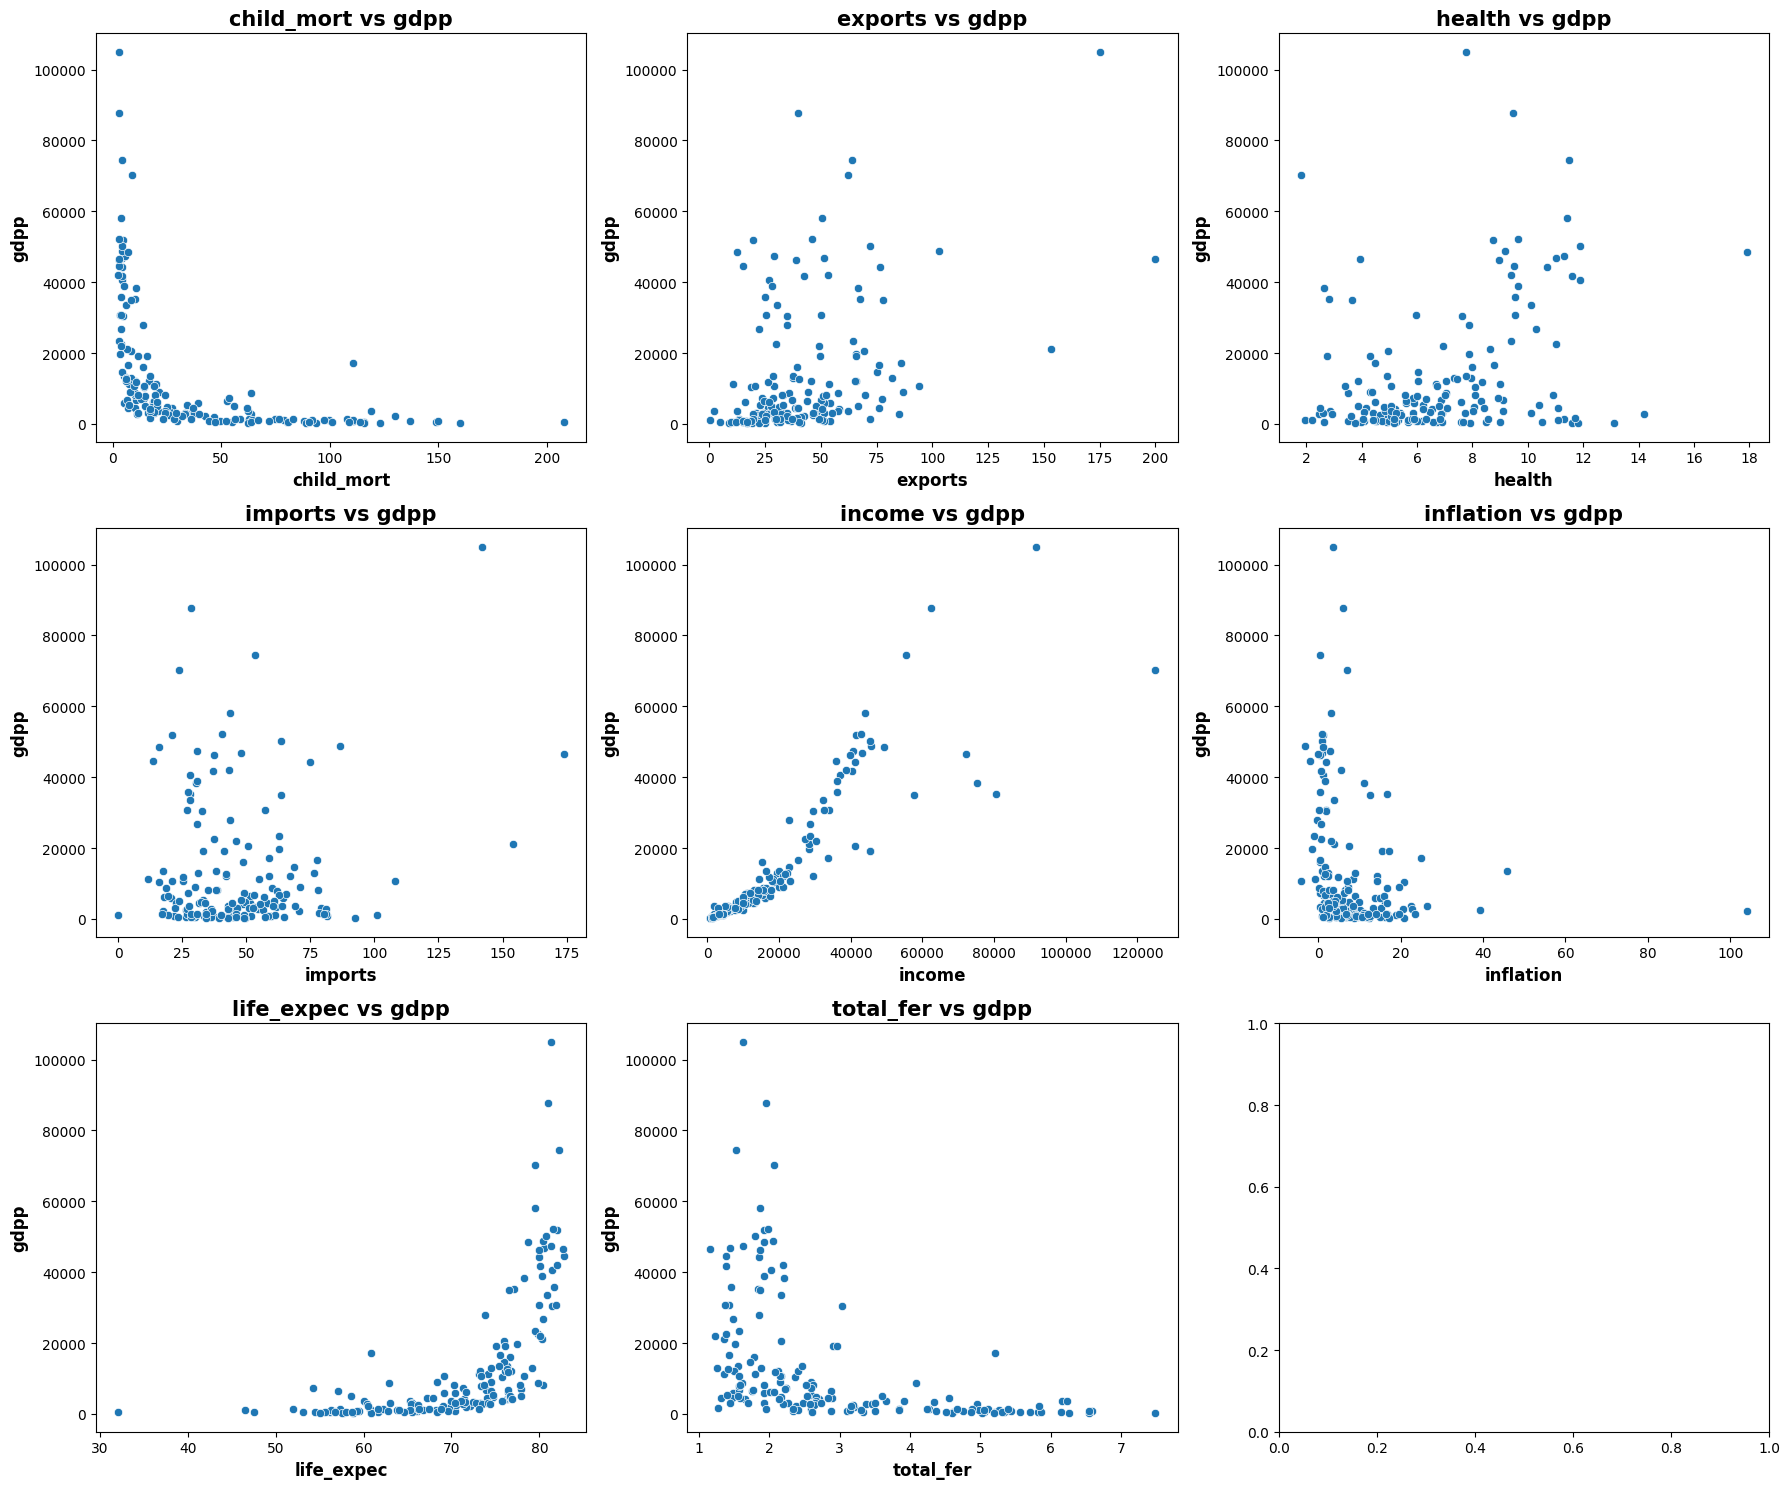

In [55]:
# Explore the continuous independent features against gdpp using scatter plots.
features_2 = df.columns[0:8]
gdpp_target = df.columns[8]

fig, axes = plt.subplots(3,3, figsize=(18,15))
axes = axes.flatten()

# Plot scatterplots for each independent features against gdpp 
for i, feature in enumerate(features_2):
    sns.scatterplot(x=df[feature], y=df[gdpp_target], ax=axes[i])
    axes[i].set_title(f"{feature} vs {gdpp_target}", fontsize=15, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12, fontweight='bold')
    axes[i].set_ylabel(gdpp_target, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

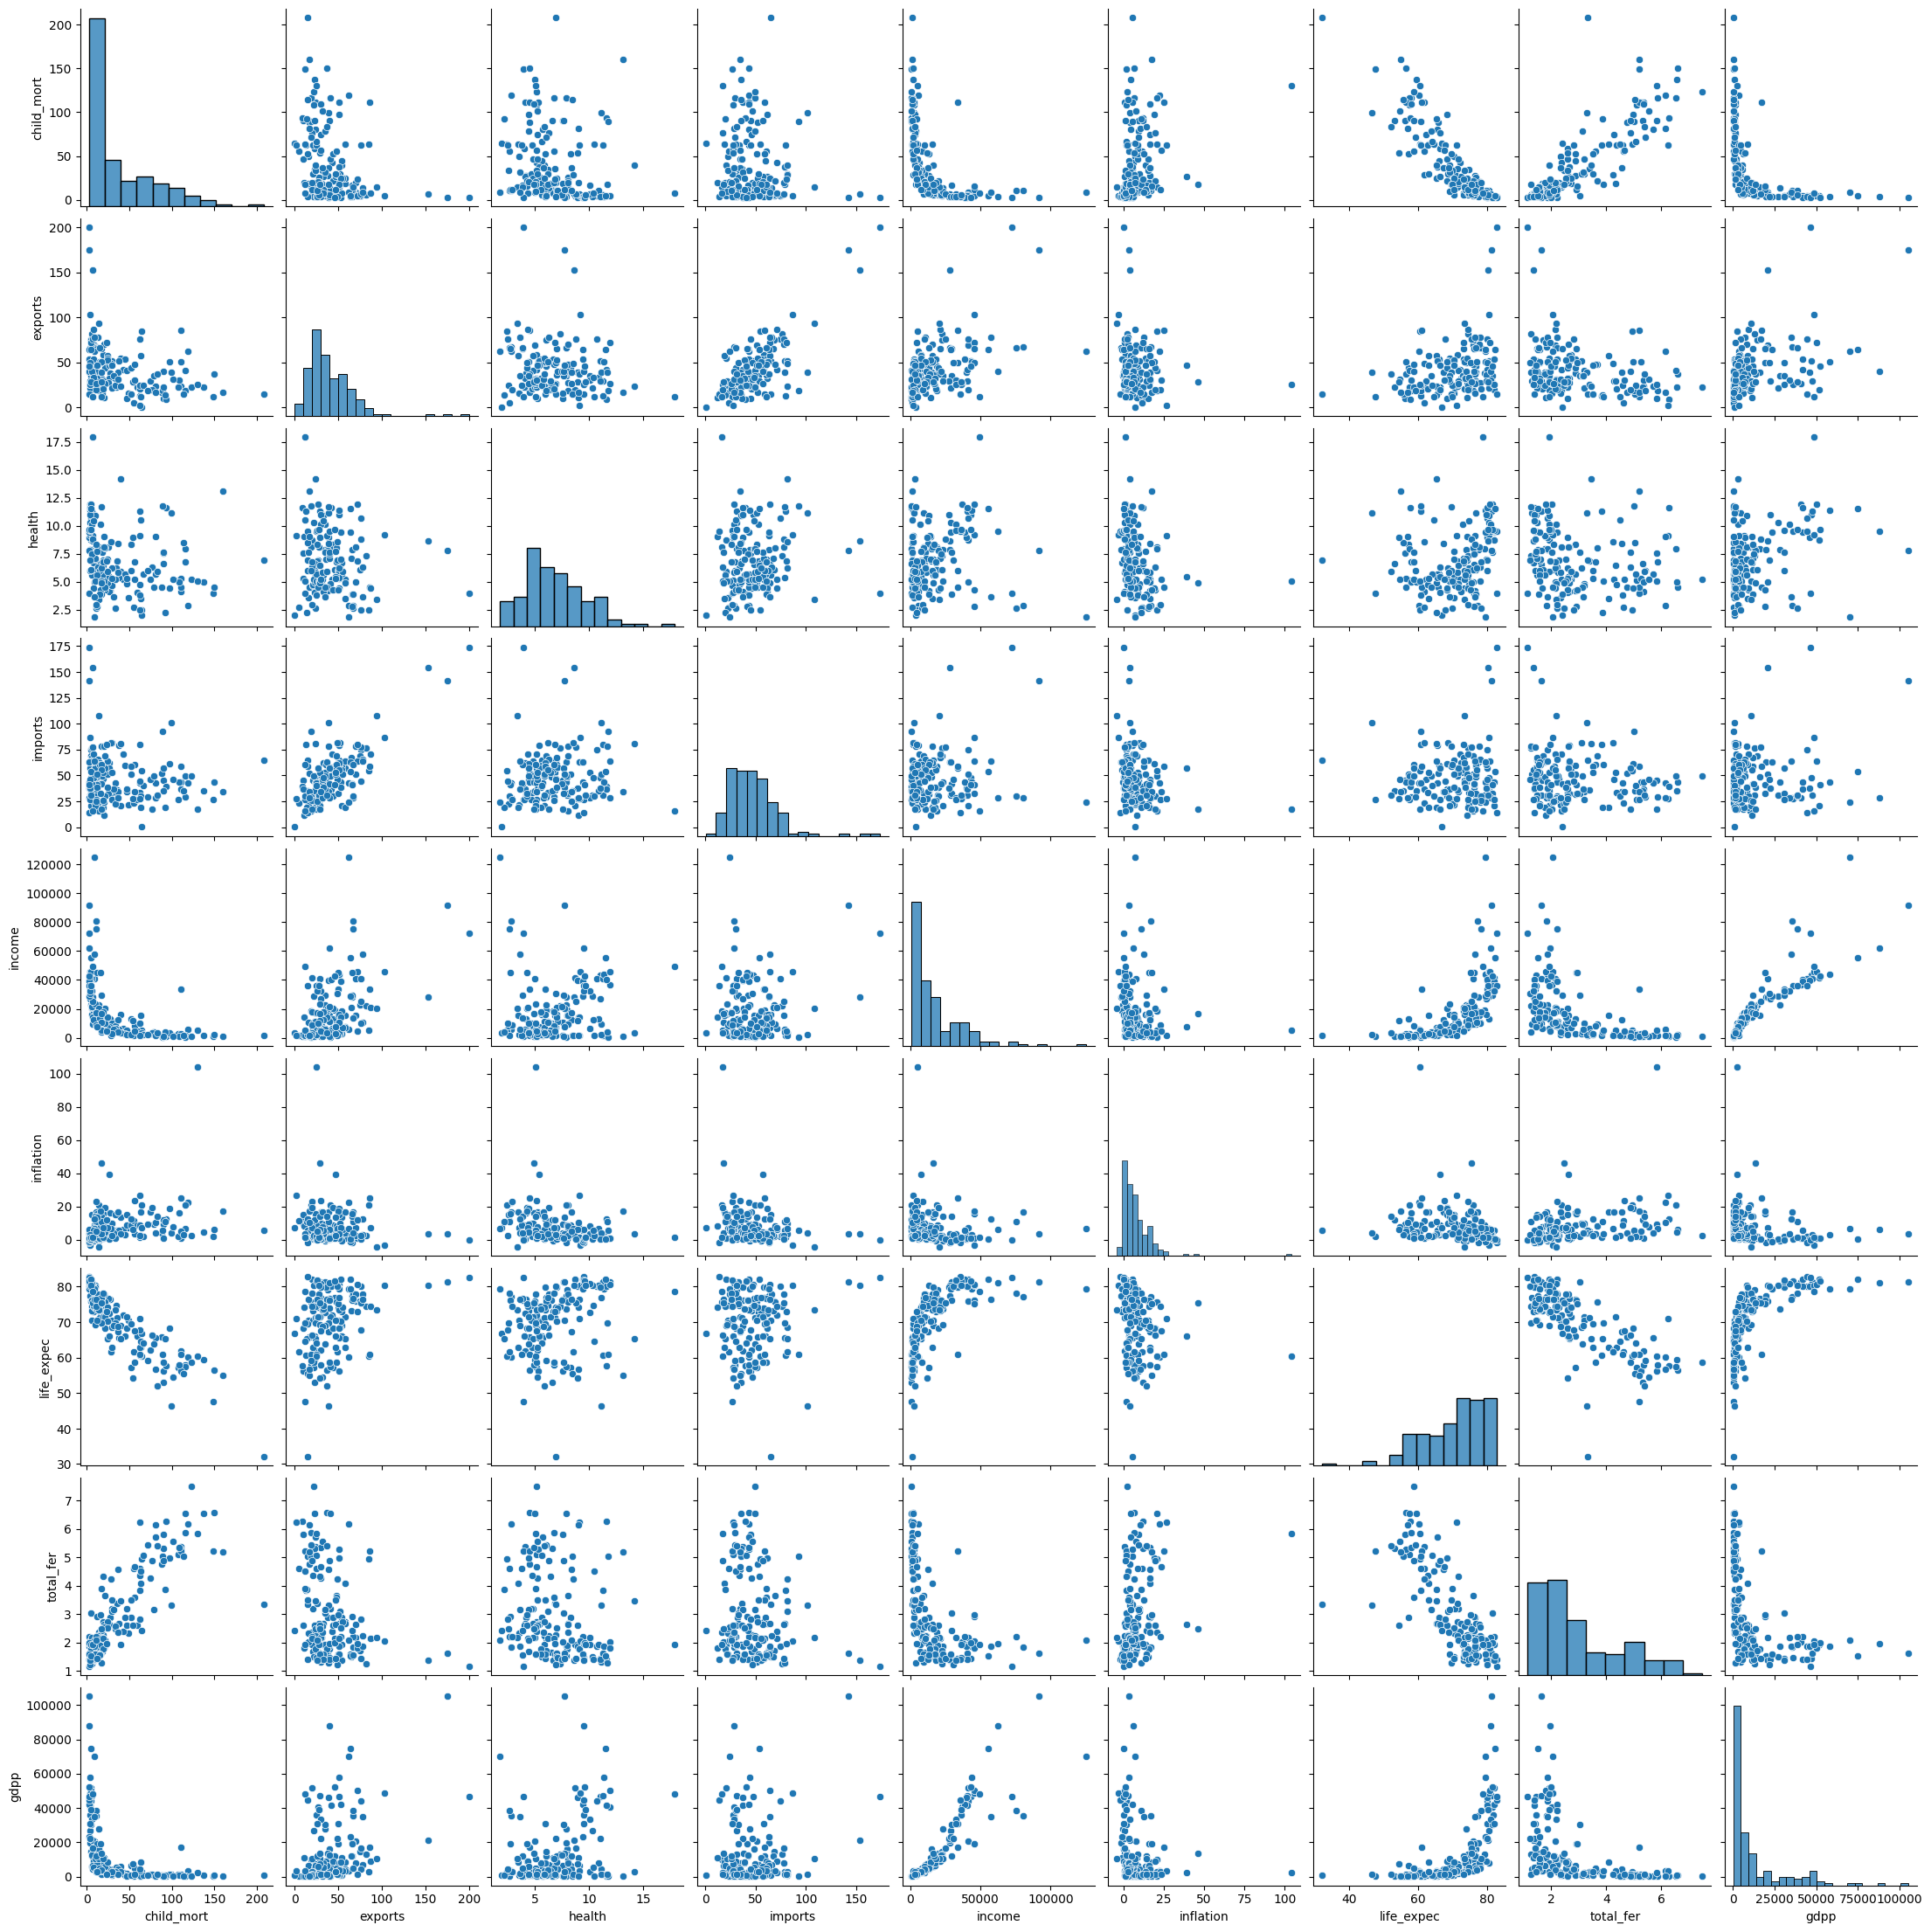

In [56]:
# Create a pair plot
# Hint: Explore seaborn pairplot

sns.pairplot(df)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [57]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

df_scaled.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


In [58]:
X = df_scaled[:].values
X

array([[0.42648491, 0.04948197, 0.35860783, ..., 0.47534517, 0.73659306,
        0.00307343],
       [0.06815969, 0.13953104, 0.29459291, ..., 0.87179487, 0.07886435,
        0.03683341],
       [0.12025316, 0.1915594 , 0.14667495, ..., 0.87573964, 0.27444795,
        0.04036499],
       ...,
       [0.10077897, 0.35965101, 0.31261653, ..., 0.8086785 , 0.12618297,
        0.01029885],
       [0.26144109, 0.1495365 , 0.20944686, ..., 0.69822485, 0.55520505,
        0.01029885],
       [0.39191821, 0.18455558, 0.25357365, ..., 0.39250493, 0.670347  ,
        0.01173057]], shape=(167, 9))

## K-Means Clustering

### Selecting K

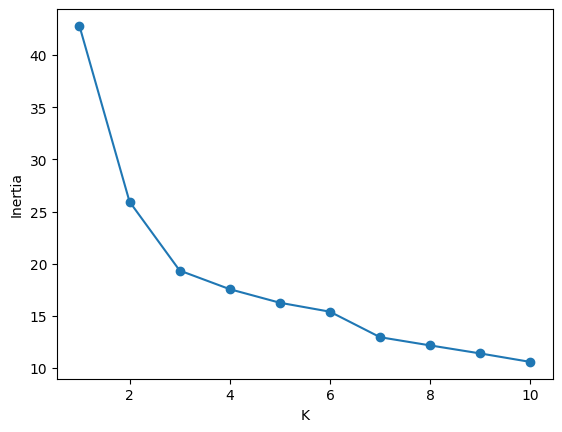

In [59]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

elbow_Kmeans(X)

The elbow runs from K=2 to k=4.To find the most optimal K value we will use the silhouette method. 

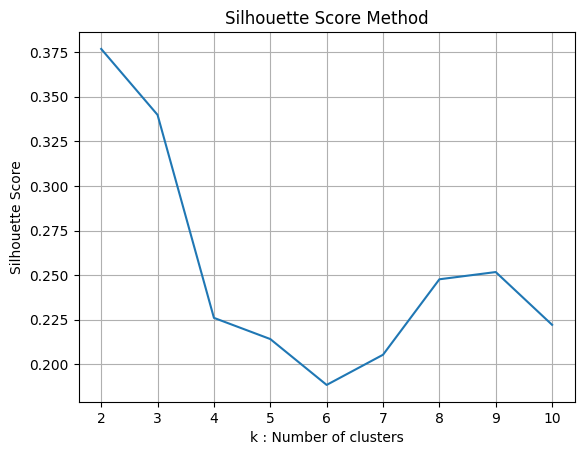

In [60]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

In [102]:
score= round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 3)
print(score)


0.377


Based on the elbow and silhouette score the most optimal K value is 2. Although, the silhouette score is quite modest, entailing an overlap between clusters. 

## Fitting a K-Means Model with the selected K value

In [61]:
# Remember to set the random_state to rseed
r=42
k=2
kmeans = KMeans(n_clusters=k, random_state=r)
kmeans.fit(df_scaled)


KMeans(n_clusters=2, random_state=42)

In [62]:
df_scaled['kmeans_2'] = kmeans.labels_

In [63]:
df_scaled

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_2
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,0
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,1
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,1
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,0
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,1
...,...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143,0
163,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650,1
164,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299,1
165,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299,0


In [64]:
# Check model performance with the silhouette coefficient
labels = kmeans.fit_predict(X)

score = silhouette_score(X, labels)
print(f"Silhouette Score for K={k}: {score}")

Silhouette Score for K=2: 0.37671430588173554


## Predictions

In [90]:
# Add the predicted cluster label column to the original dataframe

countries_df['ClusterLabel'] = kmeans.fit_predict(X)

In [91]:
countries_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterLabel
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0


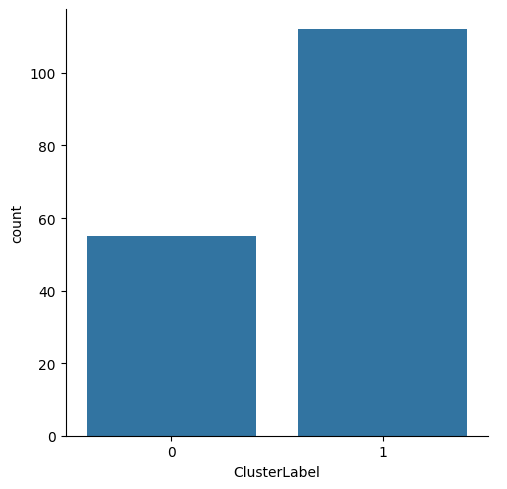

In [92]:
sns.catplot(countries_df, x='ClusterLabel', kind='count')

## Visualisation of clusters

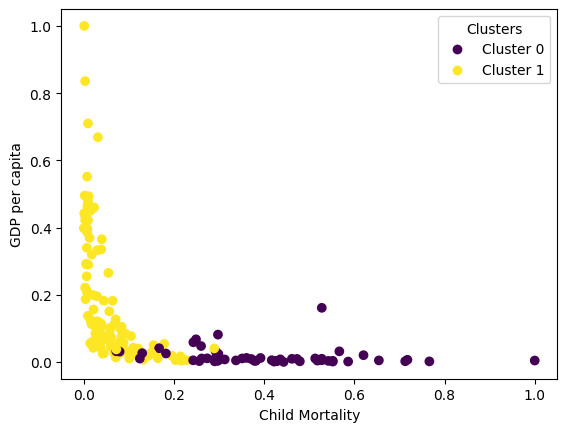

In [93]:
# Visualisation of clusters: child mortality vs gdpp
scatter = plt.scatter(x=df_scaled['child_mort'], y=df_scaled['gdpp'], c=df_scaled['kmeans_2'], cmap='viridis')
plt.xlabel('Child Mortality')
plt.ylabel('GDP per capita')

# Creating legends
unique_labels = df_scaled['kmeans_2'].unique()

handles = []
for label in unique_labels:
    handles.append(plt.Line2D([],[], marker='o', color=scatter.cmap(scatter.norm(label)),
                              linestyle = ' ', label=f"Cluster {label}"))

plt.legend(handles=handles, title='Clusters')

plt.show()

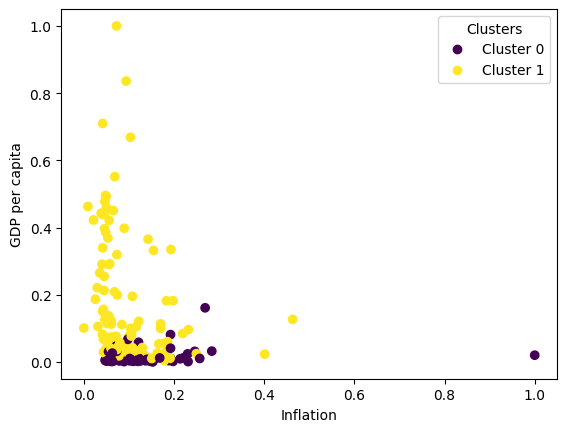

In [94]:
# Visualisation of clusters: inflation vs gdpp
scatter = plt.scatter(x=df_scaled['inflation'], y=df_scaled['gdpp'], c=df_scaled['kmeans_2'], cmap='viridis')
plt.xlabel('Inflation')
plt.ylabel('GDP per capita')

# Creating legends
unique_labels = df_scaled['kmeans_2'].unique()

handles = []
for label in unique_labels:
    handles.append(plt.Line2D([],[], marker='o', color=scatter.cmap(scatter.norm(label)),
                              linestyle = ' ', label=f"Cluster {label}"))

plt.legend(handles=handles, title='Clusters')

plt.show()

In [95]:
countries_df['ClusterLabel']

0      0
1      1
2      1
3      0
4      1
      ..
162    0
163    1
164    1
165    0
166    0
Name: ClusterLabel, Length: 167, dtype: int32

In [100]:
clusters_name = {0: 'Cluster 0', 1: 'Cluster 1'}
countries_df['CountryLabel'] = countries_df['ClusterLabel'].map(clusters_name)

fig = px.choropleth(countries_df, 
                     locationmode='country names',
                     locations='country',
                     color='CountryLabel',
                     title='Countries by labels'
                     )

fig.show()

In [97]:
countries_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterLabel,CountryLabel
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,Cluster 0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,Cluster 1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,Cluster 1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,Cluster 0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1,Cluster 1


In [98]:
countries_cluster_0 = countries_df.loc[countries_df['ClusterLabel'] == 0].iloc[:,0]
countries_array = countries_cluster_0.to_numpy()

print("Countries in cluster 0: ")
print(countries_array)


Countries in cluster 0: 
['Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'India' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Micronesia, Fed. Sts.' 'Mozambique' 'Myanmar' 'Namibia'
 'Niger' 'Nigeria' 'Pakistan' 'Rwanda' 'Samoa' 'Senegal' 'Sierra Leone'
 'Solomon Islands' 'South Africa' 'Sudan' 'Tajikistan' 'Tanzania'
 'Timor-Leste' 'Togo' 'Tonga' 'Uganda' 'Vanuatu' 'Yemen' 'Zambia']


In [99]:
countries_cluster_1 = countries_df.loc[countries_df['ClusterLabel'] == 1].iloc[:,0]
countries_array = countries_cluster_1.to_numpy()

print("Countries in cluster 1: ")
print(countries_array)

Countries in cluster 1: 
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria' 'Cambodia' 'Canada'
 'Cape Verde' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Estonia' 'Fiji' 'Finland' 'France' 'Georgia' 'Germany'
 'Greece' 'Grenada' 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Indonesia'
 'Iran' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kuwait' 'Kyrgyz Republic' 'Latvia' 'Lebanon' 'Libya' 'Lithuania'
 'Luxembourg' 'Macedonia, FYR' 'Malaysia' 'Maldives' 'Malta' 'Mauritius'
 'Moldova' 'Mongolia' 'Montenegro' 'Morocco' 'Nepal' 'Netherlands'
 'New Zealand' 'Norway' 'Oman' 'Panama' 'Paraguay' 'Peru' 'Philippines'
 'Poland' 'Portugal' 'Qatar' 'Romania' 'Russia' 'Saudi Arabia' 'Serb

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**
From the cluster figures above, we can see that Cluster 0 mostly has lower-income countries, which is characterised by the relatively high Child Mortality rates and the low GDP per capita. Many countries in this cluster face development challenges, limited healthcare infrastructure, and economic constrians. This is seen in the list of countries in Cluster 0.

In Cluster 1 we can see from the figure that there is a low Child Mortality rate but an increase in GDP per capita. This suggests that these countries are mostly high-income and developed countries, with stronger healthcare and better standards of living. 

In regards to the inflation cluster. We can see that both clusters tend to reside along the low end of inflation, indicating that relative price stability across all countries and that inflation is not a distinguishable factor between both clusters. However, Cluster 0 countries have a lower GDP per capita with a low inflation rate, reflecting lower economic output and standards of living, compared to Cluster 1 countries where similar inflation rates have an much higher GDP per capita outpit, indicating greater wealth and development in these countries. 

In summary, we can see that Cluster 0 countries are least developing countries, and Cluster 1 countries are mixed with developing and developed countries as the figures do not show significantly higher GDP per capita, the cluster tends to hover around the low-mid section of the GDP per capita. 